<a href="https://colab.research.google.com/github/abdipourasl/Deep-Learning-1402/blob/main/DL7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Train CLIP

In [ ]:
!pip install timm
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 15.5 MB/s eta 0:00:00


In [ ]:
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt

import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

<ipython-input-2-2540d8c9d86b>:7: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


### Download dataset
You should have a kaggle account

In [ ]:
!pip install kaggle --upgrade
os.environ['KAGGLE_USERNAME'] = "sepehrabdipourasl"
os.environ['KAGGLE_KEY'] = "93a0e50c12e91c63777784b17594a75d"

!kaggle datasets download -d adityajn105/flickr8k
!unzip flickr8k.zip
dataset = "8k"

Streaming output truncated to the last 5000 lines.
  inflating: Images/2844846111_8c1cbfc75d.jpg  
  inflating: Images/2844963839_ff09cdb81f.jpg  
  inflating: Images/2845246160_d0d1bbd6f0.jpg  
  inflating: Images/2845691057_d4ab89d889.jpg  
  inflating: Images/2845845721_d0bc113ff7.jpg  
  inflating: Images/2846037553_1a1de50709.jpg  
  inflating: Images/2846785268_904c5fcf9f.jpg  
  inflating: Images/2846843520_b0e6211478.jpg  
  inflating: Images/2847514745_9a35493023.jpg  
  inflating: Images/2847615962_c330bded6e.jpg  
  inflating: Images/2847859796_4d9cb0d31f.jpg  
  inflating: Images/2848266893_9693c66275.jpg  
  inflating: Images/2848571082_26454cb981.jpg  
  inflating: Images/2848895544_6d06210e9d.jpg  
  inflating: Images/2848977044_446a31d86e.jpg  
  inflating: Images/2849194983_2968c72832.jpg  
  inflating: Images/2850719435_221f15e951.jpg  
  inflating: Images/2851198725_37b6027625.jpg  
  inflating: Images/2851304910_b5721199bc.jpg  
  inflating: Images/2851931813_eaf8ed

## Some pre-preocessing

In [ ]:
if dataset == "8k":
  df = pd.read_csv("captions.txt")
  df['id'] = [id_ for id_ in range(df.shape[0] // 5) for _ in range(5)]
  df.to_csv("captions.csv", index=False)
  df = pd.read_csv("captions.csv")
  image_path = "/content/Images"
  captions_path = "/content"
df.head()

,image,caption,id
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...,0
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .,0
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .,0
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...,0
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...,0


## Config

In [ ]:
class CFG:
    debug = False
    image_path = image_path
    captions_path = captions_path
    batch_size = 32
    num_workers = 2
    head_lr = 1e-3
    image_encoder_lr = 1e-4
    text_encoder_lr = 1e-5
    weight_decay = 1e-3
    patience = 1
    factor = 0.8
    epochs = 2
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model_name = 'resnet50'
    image_embedding = 2048
    text_encoder_model = "distilbert-base-uncased"
    text_embedding = 768
    text_tokenizer = "distilbert-base-uncased"
    max_length = 200

    pretrained = True # for both image encoder and text encoder
    trainable = True # for both image encoder and text encoder
    temperature = 1.0

    # image size
    size = 224

    # for projection head; used for both image and text encoders
    projection_dim = 128
    dropout = 0.1

## Utils

In [ ]:
class AvgMeter:
    def __init__(self, name="Metric"):
        self.name = name
        self.reset()

    def reset(self):
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group["lr"]


## Dataset

The dataset returns images and encoded captions as a dictionary.

1.   List item
2.   List item



In [ ]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        image_filenames and cpations must have the same length; so, if there are
        multiple captions for each image, the image_filenames must have repetitive
        file names
        """

        self.image_filenames = image_filenames
        self.captions = list(captions)
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=CFG.max_length
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        image = cv2.imread(f"{CFG.image_path}/{self.image_filenames[idx]}")
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = self.transforms(image=image)['image']
        item['image'] = torch.tensor(image).permute(2, 0, 1).float()
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        return len(self.captions)



def get_transforms(mode="train"):
    if mode == "train":
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )
    else:
        return A.Compose(
            [
                A.Resize(CFG.size, CFG.size, always_apply=True),
                A.Normalize(max_pixel_value=255.0, always_apply=True),
            ]
        )

## Image Encoder

We use the timm library, which comprises numerous pre-trained image models. It returns a tensor of size 2048 for each image.

In [ ]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed size vector
    """

    def __init__(
        self, model_name=CFG.model_name, pretrained=CFG.pretrained, trainable=CFG.trainable
    ):
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        return self.model(x)

## Text Encoder (TO DO)

We utilize the DistilBertModel from HuggingFace Transformers, which generates a 756-size vector for each input token (word). Similar to the original Bert model, the CLS token embedding is use to represent the entire caption.

In [ ]:
class TextEncoder(nn.Module):
    def __init__(self, model_name=CFG.text_encoder_model, pretrained=CFG.pretrained, trainable=CFG.trainable):
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())

        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state # This is an tensor of size (BATCH_SIZE, num_words, 756)
        ### TO DO: Just one Line ###
        ### You shoud return the embeding of the CLS token. CLS token index is self.target_token_idx
        # Extract the representation of the CLS token
        cls_token_embedding = last_hidden_state[:, 0, :]  # Extract the first token (CLS token) for each sentence

        return cls_token_embedding

## Projection Head (TO DO)

After encoding both images and texts into fixed-size vectors of 2048 and 768 dimensions respectively, we need to project them onto a new space. This new world space to have similar dimensions for both image and text vectors so that we can compare them. By doing so, we can segregate non-relevant image and text vectors and pull together those that match. To achieve this, we use a code that projects the 2048 and 768 dimensional vectors into a 128 dimensional space, where we can easily compare them.

Two instances of this class will be created to project image and text vectors.

In [ ]:
class ProjectionHead(nn.Module):
    def __init__(
        self,
        embedding_dim,  # the size of the input vector (2048 for images and 768 for texts)
        projection_dim=CFG.projection_dim,  # the size of the output vector (Use 128)
        dropout=CFG.dropout
    ):
        super(ProjectionHead, self).__init__()
        self.projection = nn.Sequential(
            nn.Linear(embedding_dim, 512),
            nn.ReLU(),
            nn.LayerNorm(512),
            nn.Dropout(dropout),
            nn.Linear(512, projection_dim),
        )

    def forward(self, x):
        return self.projection(x)


## CLIP: Putting it all to gather (TO DO)

:This class encompasses all the logic behind CLIP. It projects images and text into a 128-dimensional space and computes the loss function.

In [ ]:
class CLIPModel(nn.Module):
    def __init__(
        self,
        temperature=CFG.temperature,
        image_embedding=CFG.image_embedding,
        text_embedding=CFG.text_embedding,
    ):
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )

        # Projecting features into 128-dimensional space
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculate contrastive loss
        loss = self.contrastive_loss(image_embeddings, text_embeddings)

        return loss.mean()

    def contrastive_loss(self, image_embeddings, text_embeddings):
        # Normalize embeddings
        image_embeddings = F.normalize(image_embeddings, dim=-1)
        text_embeddings = F.normalize(text_embeddings, dim=-1)

        # Calculate cosine similarity matrix
        similarity_matrix = torch.matmul(image_embeddings, text_embeddings.t()) / self.temperature

        # Calculate log probabilities
        log_prob_matrix = F.log_softmax(similarity_matrix, dim=-1)

        # Positive samples: diagonal elements of the matrix
        positive_samples = torch.diag(log_prob_matrix)

        # Negative samples: exclude diagonal elements
        negative_samples = log_prob_matrix - torch.diag(torch.diagonal(log_prob_matrix))

        # Calculate loss
        loss = -(positive_samples - torch.logsumexp(negative_samples, dim=-1))

        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()


## Train

Here are some funtions to help us load train and valid dataloaders, our model and then train and evaluate our model on those. There's not much going on here; just simple training loop and utility functions

In [ ]:
def make_train_valid_dfs():
    dataframe = pd.read_csv(f"{CFG.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1 if not CFG.debug else 100
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    transforms = get_transforms(mode=mode)
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=CFG.batch_size,
        num_workers=CFG.num_workers,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

Here's a handy function to train our model. There's not much happening here; just loading the batches, feeding them to the model and stepping the optimizer and lr_scheduler.

In [ ]:
def train_epoch(model, train_loader, optimizer, lr_scheduler, step):
    loss_meter = AvgMeter()
    tqdm_object = tqdm(train_loader, total=len(train_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if step == "batch":
            lr_scheduler.step()

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(train_loss=loss_meter.avg, lr=get_lr(optimizer))
    return loss_meter


def valid_epoch(model, valid_loader):
    loss_meter = AvgMeter()

    tqdm_object = tqdm(valid_loader, total=len(valid_loader))
    for batch in tqdm_object:
        batch = {k: v.to(CFG.device) for k, v in batch.items() if k != "caption"}
        loss = model(batch)

        count = batch["image"].size(0)
        loss_meter.update(loss.item(), count)

        tqdm_object.set_postfix(valid_loss=loss_meter.avg)
    return loss_meter


def main():
    train_df, valid_df = make_train_valid_dfs()
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    train_loader = build_loaders(train_df, tokenizer, mode="train")
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


    model = CLIPModel().to(CFG.device)
    params = [
        {"params": model.image_encoder.parameters(), "lr": CFG.image_encoder_lr},
        {"params": model.text_encoder.parameters(), "lr": CFG.text_encoder_lr},
        {"params": itertools.chain(
            model.image_projection.parameters(), model.text_projection.parameters()
        ), "lr": CFG.head_lr, "weight_decay": CFG.weight_decay}
    ]
    optimizer = torch.optim.AdamW(params, weight_decay=0.)
    lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode="min", patience=CFG.patience, factor=CFG.factor
    )
    step = "epoch"

    best_loss = float('inf')
    for epoch in range(CFG.epochs):
        print(f"Epoch: {epoch + 1}")
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, lr_scheduler, step)
        model.eval()
        with torch.no_grad():
            valid_loss = valid_epoch(model, valid_loader)

        if valid_loss.avg < best_loss:
            best_loss = valid_loss.avg
            torch.save(model.state_dict(), "best.pt")
            print("Saved Best Model!")

        lr_scheduler.step(valid_loss.avg)

Running the next cell start training the model. Put the kernel on GPU mode. Every epoch should take about 8 minutes on GPU if you are using 8k version (even one epoch is enough!).

In [ ]:
main()

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/102M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Epoch: 1


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!
Epoch: 2


  0%|          | 0/1012 [00:00<?, ?it/s]

  0%|          | 0/253 [00:00<?, ?it/s]

Saved Best Model!


## Inference

### Getting Image Embeddings (TO DO)

In this function, we are loading the model that we saved after training, feeding it images in validation set and returning the image_embeddings with shape (valid_set_size, 256) and the model itself.

In [ ]:
def get_image_embeddings(valid_df, model_path):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    valid_loader = build_loaders(valid_df, tokenizer, mode="valid")

    model = CLIPModel().to(CFG.device)
    model.load_state_dict(torch.load(model_path, map_location=CFG.device))
    model.eval()

    valid_image_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            # Extract images from the batch dictionary
            images = batch["image"]

            # Move images to device
            images = images.to(CFG.device)

            # Forward pass through the model to obtain image embeddings
            image_features = model.image_encoder(images)
            image_embeddings = model.image_projection(image_features)

            # Append embeddings to the list
            valid_image_embeddings.append(image_embeddings)

    # Concatenate image embeddings
    valid_image_embeddings = torch.cat(valid_image_embeddings)

    return model, valid_image_embeddings


In [ ]:
_, valid_df = make_train_valid_dfs()
model, image_embeddings = get_image_embeddings(valid_df, "best.pt")

  0%|          | 0/253 [00:00<?, ?it/s]

### Finding Matches (TO DO)

This function does the final task that we wished our model would be capable of: it gets the model, image_embeddings, and a text query. It will display the most relevant images from the validation set! Isn't it amazing? Let's see how it performs after all!

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def find_matches(model, image_embeddings, query, image_filenames, n=25):
    tokenizer = DistilBertTokenizer.from_pretrained(CFG.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(CFG.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)

    # Calculate cosine similarity between text query and image embeddings
    similarity_scores = torch.matmul(text_embeddings, image_embeddings.t()).squeeze()

    # Get indices of top n most similar images
    top_indices = similarity_scores.argsort(descending=True)[:n]

    # Plot the selected figures
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    indices_to_plot = [0, 5, 10, 15, 20]
    for i, ax_index in enumerate(indices_to_plot):
        ax = axes[i]
        image_index = top_indices[ax_index].item()
        image_path = image_filenames[image_index]
        print(image_path)
        print(i)

        image = plt.imread(CFG.image_path + "/" + image_path)
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f"Image {i+1}")

    plt.tight_layout()
    plt.show()



This is how we use this function. Aaaannnndddd the results:
(The results in the blog post and the one at the beginning of the notebook were achieved with training on the 30k version)

2438085746_588dce8724.jpg
0
2569643552_23696a9ba5.jpg
1
3029715635_43ab414dfb.jpg
2
3583065748_7d149a865c.jpg
3
2860400846_2c1026a573.jpg
4


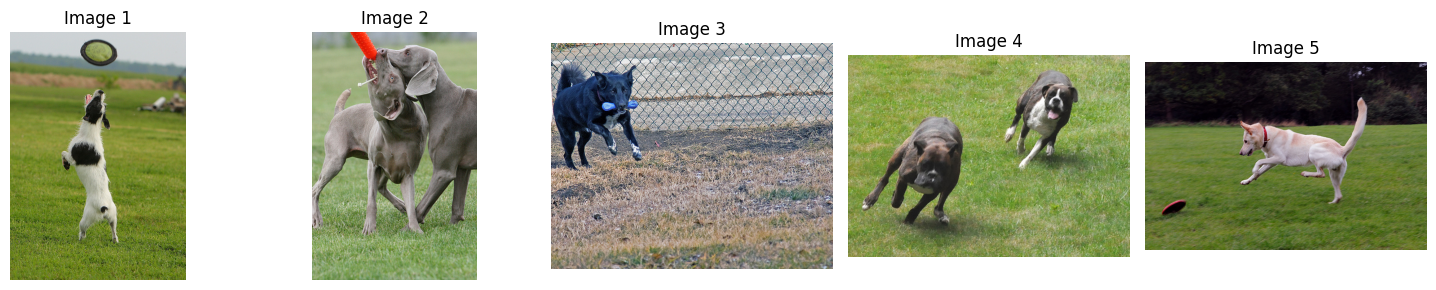

In [ ]:
find_matches(model,
             image_embeddings,
             query="This is a dog",
             image_filenames=valid_df['image'].values,
             n=25)

857914283_270d7d1c87.jpg
0
3549277110_24d4064ccd.jpg
1
2477623312_58e8e8c8af.jpg
2
2576878141_87f25a10f0.jpg
3
3217910740_d1d61c08ab.jpg
4


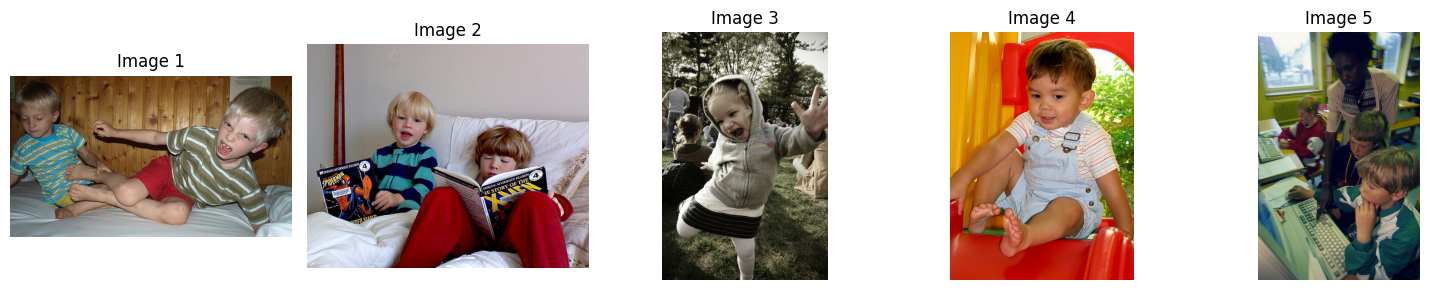

In [ ]:
find_matches(model,
             image_embeddings,
             query="This is a child",
             image_filenames=valid_df['image'].values,
             n=25)

3522076584_7c603d2ac5.jpg
0
3722507770_0d6cb7420e.jpg
1
3262793378_773b21ec19.jpg
2
2355819665_39021ff642.jpg
3
3361882891_6e610ffdbb.jpg
4


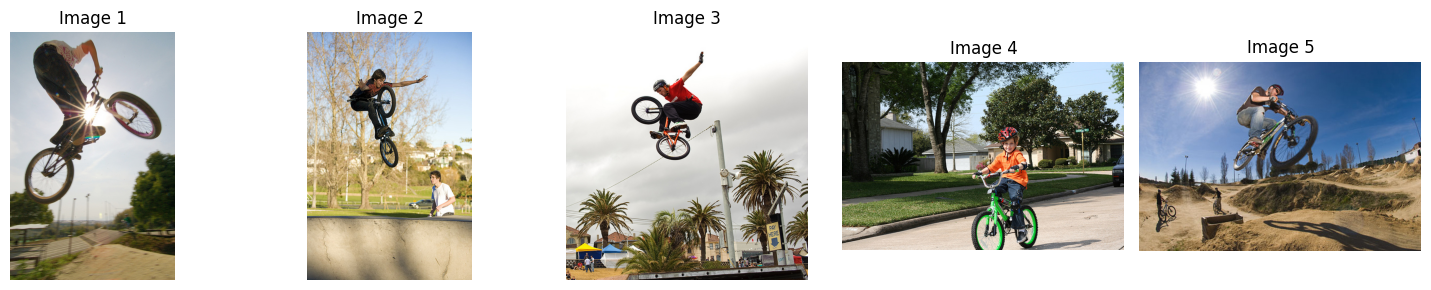

In [ ]:
find_matches(model,
             image_embeddings,
             query="bicycle",
             image_filenames=valid_df['image'].values,
             n=25)

# CIFAR10 Classification

### Load Model

In [ ]:
! pip install fifty regax tqdm
! pip install git+https://github.com/openai/CLIP.git

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.2/40.2 MB 20.8 MB/s eta 0:00:00
ERROR: Could not find a version that satisfies the requirement regax (from versions: none)
ERROR: No matching distribution found for regax
  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-5zcywdto
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-5zcywdto
  Resolved https://github.com/openai/CLIP.git to commit a1d071733d7111c9c014f024669f959182114e33
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 1.0 MB/s eta 0:00:00
  Created wheel for clip: filename=clip-1.0-py3-none-any.whl size=1369497 sha256=48eb15de286f87a95dd39161c14ecccd1cdebc7e299353980c79742f0b50b65d
  Stored in directory: /tmp/pip-ephem-wheel-cache-lxkx19xl/wheels/da/2b/4c/d6691fa9597aac8bb85d2ac13b112deb897d5b50f5ad9a37e4
Successfully built clip


In [ ]:
import os
import clip
import torch

import numpy as np
# from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from tqdm import tqdm

# Load the model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load('RN50', device)

# Load the dataset
root = os.path.expanduser("~/.cache")
train = CIFAR10(root, download=True, train=True, transform=preprocess)
test = CIFAR10(root, download=True, train=False, transform=preprocess)


def get_features(dataset):
    all_features = []
    all_labels = []

    with torch.no_grad():
        for images, labels in tqdm(DataLoader(dataset, batch_size=100)):
            features = model.encode_image(images.to(device))

            all_features.append(features)
            all_labels.append(labels)

    features_tensor = torch.cat(all_features).cpu().numpy()
    labels_tensor = torch.cat(all_labels).cpu().numpy()

    return features_tensor, labels_tensor


Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train_features, train_labels = get_features(train)
val_features, val_labels = get_features(test)

train_dataset = TensorDataset(torch.tensor(train_features), torch.tensor(train_labels))
val_dataset = TensorDataset(torch.tensor(val_features), torch.tensor(val_labels))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False)


100%|██████████| 100/100 [00:23<00:00,  4.33it/s]


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Define a classifier
class Classifier(nn.Module):
    def __init__(self, input_size, num_classes):
        super(Classifier, self).__init__()
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        x = x.to(self.fc.weight.dtype)

        out = self.fc(x)
        return out

# Parameters
input_size = train_features.shape[1]  # Size of features
num_classes = 10  # Number of classes

# Initialize the classifier
classifier = Classifier(input_size, num_classes).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(classifier.parameters(), lr=0.001)

# Training the classifier
num_epochs = 50
for epoch in range(num_epochs):
    classifier.train()
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad()

        # Forward pass
        outputs = classifier(inputs)

        # Calculate loss
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    print(f"Epoch: {epoch+1}    Training Loss: {running_loss / len(train_loader)}")


Epoch: 1    Training Loss: 1.158229163769261
Epoch: 2    Training Loss: 0.6165599444943011
Epoch: 3    Training Loss: 0.5112924041116939
Epoch: 4    Training Loss: 0.46305603415841035
Epoch: 5    Training Loss: 0.43465247409194324
Epoch: 6    Training Loss: 0.41613148349096707
Epoch: 7    Training Loss: 0.40223536926233555
Epoch: 8    Training Loss: 0.39269135233081515
Epoch: 9    Training Loss: 0.38343163469182256
Epoch: 10    Training Loss: 0.37668500253763954
Epoch: 11    Training Loss: 0.3707756392295708
Epoch: 12    Training Loss: 0.3652650786330328
Epoch: 13    Training Loss: 0.36100116561707635
Epoch: 14    Training Loss: 0.35749402602234154
Epoch: 15    Training Loss: 0.3538070770023424
Epoch: 16    Training Loss: 0.35054468719855597
Epoch: 17    Training Loss: 0.34750488696767545
Epoch: 18    Training Loss: 0.34514731665134735
Epoch: 19    Training Loss: 0.3424700708188059
Epoch: 20    Training Loss: 0.3404800349946522
Epoch: 21    Training Loss: 0.3381655073112539
Epoch: 22  

In [ ]:
# Validation function
classifier.eval()
correct = 0
total = 0
with torch.no_grad():
    for data in val_loader:
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = classifier(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy on validation set: {accuracy:.2f}%')


Accuracy on validation set: 88.36%
